In [ ]:
pip install basemap

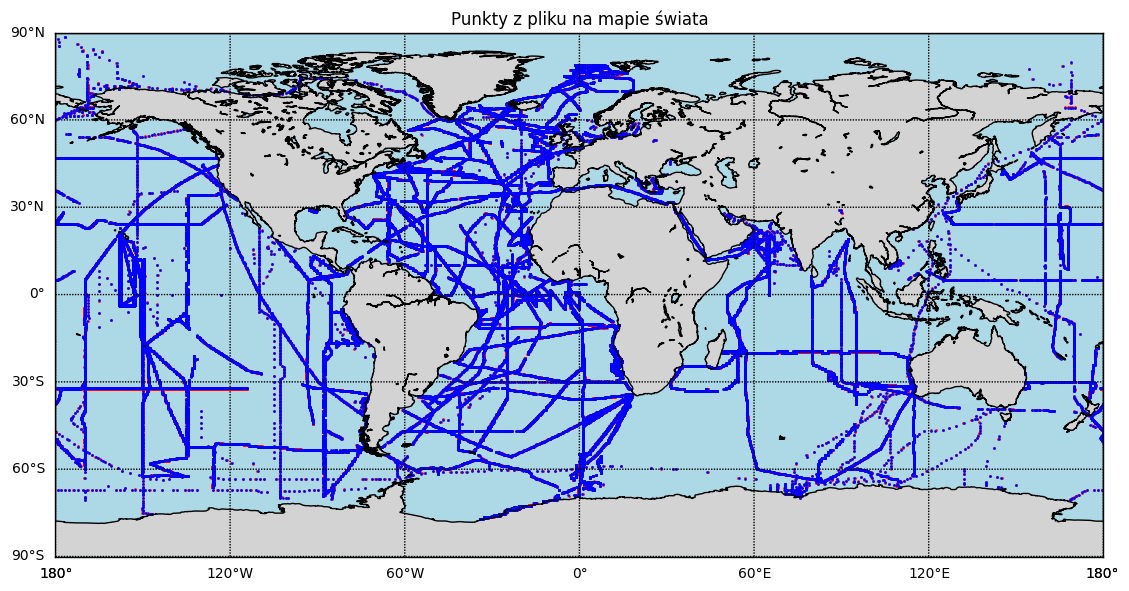

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap


df = pd.read_csv('yang_woa_grid_shallow.csv')
lat_col_y = 'lat_yang'
lon_col_y = 'lon_yang'
lat_col_w = 'lat_woa'
lon_col_w = 'lon_woa'


plt.figure(figsize=(12, 6))
m = Basemap(projection='cyl', resolution='l')

m.drawcoastlines()
m.drawmapboundary(fill_color='lightblue')
m.fillcontinents(color='lightgray', lake_color='lightblue')
m.drawparallels(np.arange(-90, 91, 30), labels=[1,0,0,0])
m.drawmeridians(np.arange(-180, 181, 60), labels=[0,0,0,1])

x, y = m(df[lon_col_y].values, df[lat_col_y].values)
m.scatter(x, y, s=1, c='red', alpha=0.9, marker='o')

x, y = m(df[lon_col_w].values, df[lat_col_w].values)
m.scatter(x, y, s=1, c='blue', alpha=0.9, marker='o')

plt.title('Punkty z pliku na mapie świata')
plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from scipy.spatial import cKDTree
from tqdm import tqdm

df_woa = pd.read_csv('woa_grid_shallow.csv')
df_joined = pd.read_csv('yang_woa_grid_shallow.csv')


tree = cKDTree(df_woa[['lat', 'lon']].values)

# znajdź indeksy 8 najbliższych punktów dla wszystkich punktów w df_joined
distances, indices = tree.query(df_joined[['lat_woa', 'lon_woa']].values, k=8)


expanded_rows = []

for i, row in tqdm(df_joined.iterrows(), total=len(df_joined), desc='Dołączanie punktów'):
    neighbors = df_woa.iloc[indices[i]].reset_index(drop=True)

    base_data = row
    neighbors_data = {}

    for j in range(len(neighbors)):
        neighbor_row = neighbors.iloc[j]
        prefix = f'neigh_{j}_'
        for col in neighbor_row.index:
            neighbors_data[prefix + col] = neighbor_row[col]

    combined_row = pd.concat([base_data, pd.Series(neighbors_data)])
    expanded_rows.append(combined_row)

df_result = pd.DataFrame(expanded_rows)


Dołączanie punktów: 100%|██████████| 128559/128559 [02:00<00:00, 1066.84it/s]


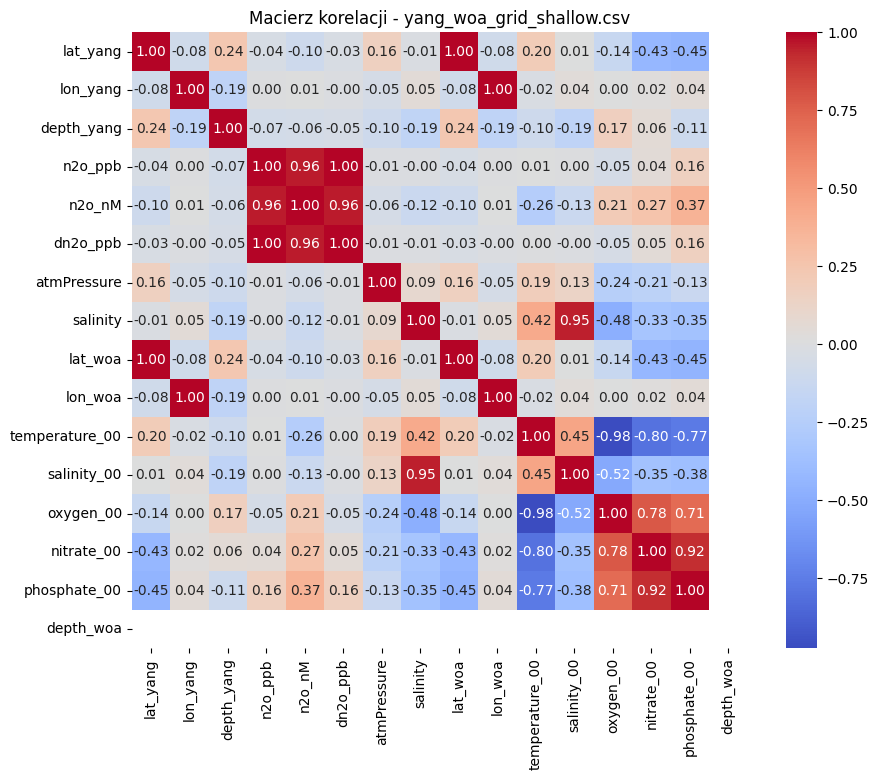

In [75]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

corr = df_joined.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title('Macierz korelacji - yang_woa_grid_shallow.csv')
plt.show()


In [ ]:
len(df_result.columns)

80

In [ ]:
df_result.columns

Index(['lat_yang', 'lon_yang', 'depth_yang', 'n2o_ppb', 'n2o_nM', 'dn2o_ppb',
       'atmPressure', 'salinity', 'lat_woa', 'lon_woa', 'temperature_00',
       'salinity_00', 'oxygen_00', 'nitrate_00', 'phosphate_00', 'depth_woa',
       'neigh_0_lat', 'neigh_0_lon', 'neigh_0_temperature_00',
       'neigh_0_salinity_00', 'neigh_0_oxygen_00', 'neigh_0_nitrate_00',
       'neigh_0_phosphate_00', 'neigh_0_depth', 'neigh_1_lat', 'neigh_1_lon',
       'neigh_1_temperature_00', 'neigh_1_salinity_00', 'neigh_1_oxygen_00',
       'neigh_1_nitrate_00', 'neigh_1_phosphate_00', 'neigh_1_depth',
       'neigh_2_lat', 'neigh_2_lon', 'neigh_2_temperature_00',
       'neigh_2_salinity_00', 'neigh_2_oxygen_00', 'neigh_2_nitrate_00',
       'neigh_2_phosphate_00', 'neigh_2_depth', 'neigh_3_lat', 'neigh_3_lon',
       'neigh_3_temperature_00', 'neigh_3_salinity_00', 'neigh_3_oxygen_00',
       'neigh_3_nitrate_00', 'neigh_3_phosphate_00', 'neigh_3_depth',
       'neigh_4_lat', 'neigh_4_lon', 'neigh_4_te

In [ ]:
def random_geo_patches(df, lat_col='lat_yang', lon_col='lon_yang',
                       patch_deg=10, n_patches=40, seed=42):
    rng = np.random.RandomState(seed)

    lat_min, lat_max = df[lat_col].min(), df[lat_col].max()
    lon_min, lon_max = df[lon_col].min(), df[lon_col].max()

    lat_bins = np.arange(np.floor(lat_min / patch_deg) * patch_deg,
                         np.ceil(lat_max / patch_deg) * patch_deg + patch_deg,
                         patch_deg)
    lon_bins = np.arange(np.floor(lon_min / patch_deg) * patch_deg,
                         np.ceil(lon_max / patch_deg) * patch_deg + patch_deg,
                         patch_deg)

    grid = [(lat_bins[i], lat_bins[i]+patch_deg,
             lon_bins[j], lon_bins[j]+patch_deg)
            for i in range(len(lat_bins)-1)
            for j in range(len(lon_bins)-1)]

    rng.shuffle(grid)

    selected = []
    mask = np.zeros(len(df), dtype=bool)
    for bbox in grid:
        if len(selected) >= n_patches:
            break
        la0, la1, lo0, lo1 = bbox
        inside = (
            df[lat_col].between(la0, la1, inclusive="left") &
            df[lon_col].between(lo0, lo1, inclusive="left")
        )
        if inside.any():
            selected.append(bbox)
            mask |= inside

    return selected, mask


In [ ]:
patch_list, global_test_mask = random_geo_patches(
    df_result,
    lat_col='lat_yang',
    lon_col='lon_yang',
    patch_deg=10,
    n_patches=40,
    seed=42
)

print(f"Train: {(~global_test_mask).sum():,d}  |  Test: {global_test_mask.sum():,d} "
      f"({global_test_mask.mean():.2%} of total) in {len(patch_list)} patches")


Train: 115,162  |  Test: 13,397 (10.42% of total) in 40 patches


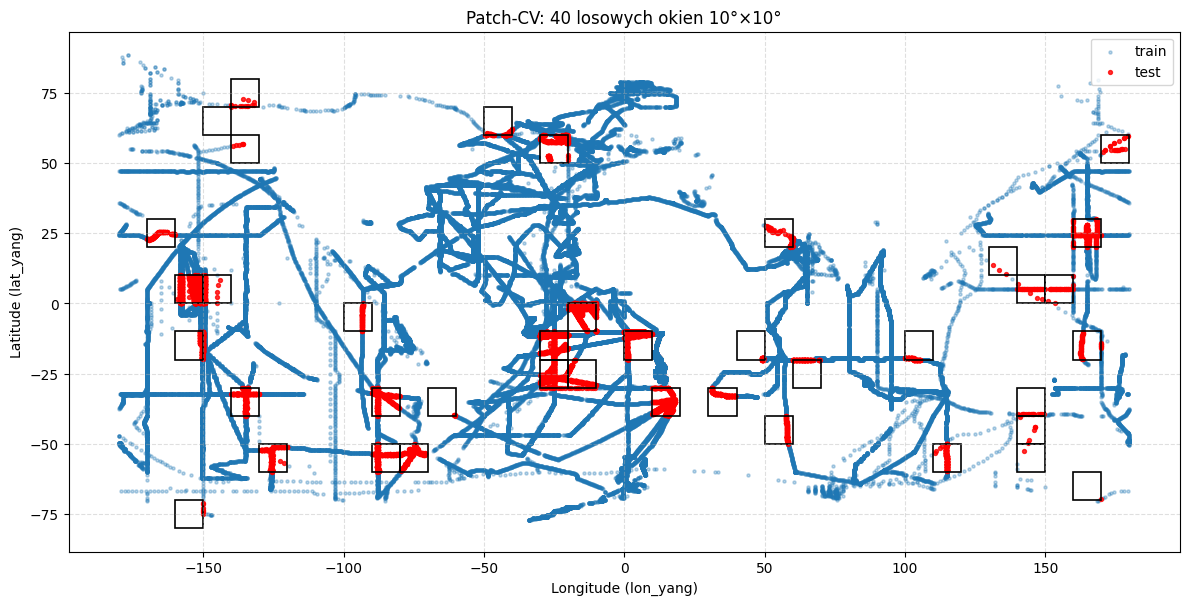

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(12, 6))

# Punkty treningowe (nie w patchach)
ax.scatter(df_result.loc[~global_test_mask, "lon_yang"],
           df_result.loc[~global_test_mask, "lat_yang"],
           s=5, alpha=0.3, label="train")

# Punkty testowe (w patchach)
ax.scatter(df_result.loc[global_test_mask, "lon_yang"],
           df_result.loc[global_test_mask, "lat_yang"],
           s=8, alpha=0.8, color="red", label="test")

for la0, la1, lo0, lo1 in patch_list:
    ax.add_patch(Rectangle((lo0, la0),
                           lo1 - lo0,
                           la1 - la0,
                           fill=False,
                           edgecolor="black",
                           linewidth=1.2))

ax.set(title="Patch-CV: 40 losowych okien 10°×10°",
       xlabel="Longitude (lon_yang)",
       ylabel="Latitude (lat_yang)")
ax.legend(loc="upper right")
ax.set_aspect("equal", adjustable="box")
ax.grid(ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
df_train = df_result.loc[~global_test_mask].copy()
df_test = df_result.loc[global_test_mask].copy()

print(f"Train size: {len(df_train)}")
print(f"Test size: {len(df_test)}")

Train size: 115162
Test size: 13397


In [ ]:
target_col = 'dn2o_ppb'

X_train = df_train.drop(columns=[target_col, 'n2o_ppb', 'n2o_nM', 'lat_yang', 'lon_yang', 'depth_yang', 'n2o_nM','atmPressure', 'salinity'])
y_train = df_train[target_col]

X_test = df_test.drop(columns=[target_col, 'n2o_ppb', 'n2o_nM', 'lat_yang', 'lon_yang', 'depth_yang', 'n2o_nM','atmPressure', 'salinity'])
y_test = df_test[target_col]


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

N_JOBS = -1
SEED = 42

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    reg_lambda=1.0,
    device='cuda',
    n_jobs=N_JOBS,
    random_state=SEED,
)

def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<18} MSE={mse:.4f} RMSE={rmse:.4f} MAE={mae:.4f}  R2={r2:.4f}")


xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
evaluate("XGBoost", y_test, pred_xgb)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:09:08] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:09:08] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBoost            MSE=674.1318 RMSE=25.9640 MAE=14.2990  R2=-0.0156


In [ ]:
patch_list, global_test_mask = random_geo_patches(
    df_joined,
    lat_col='lat_yang',
    lon_col='lon_yang',
    patch_deg=10,
    n_patches=40,
    seed=42
)

print(f"Train: {(~global_test_mask).sum():,d}  |  Test: {global_test_mask.sum():,d} "
      f"({global_test_mask.mean():.2%} of total) in {len(patch_list)} patches")


Train: 115,162  |  Test: 13,397 (10.42% of total) in 40 patches


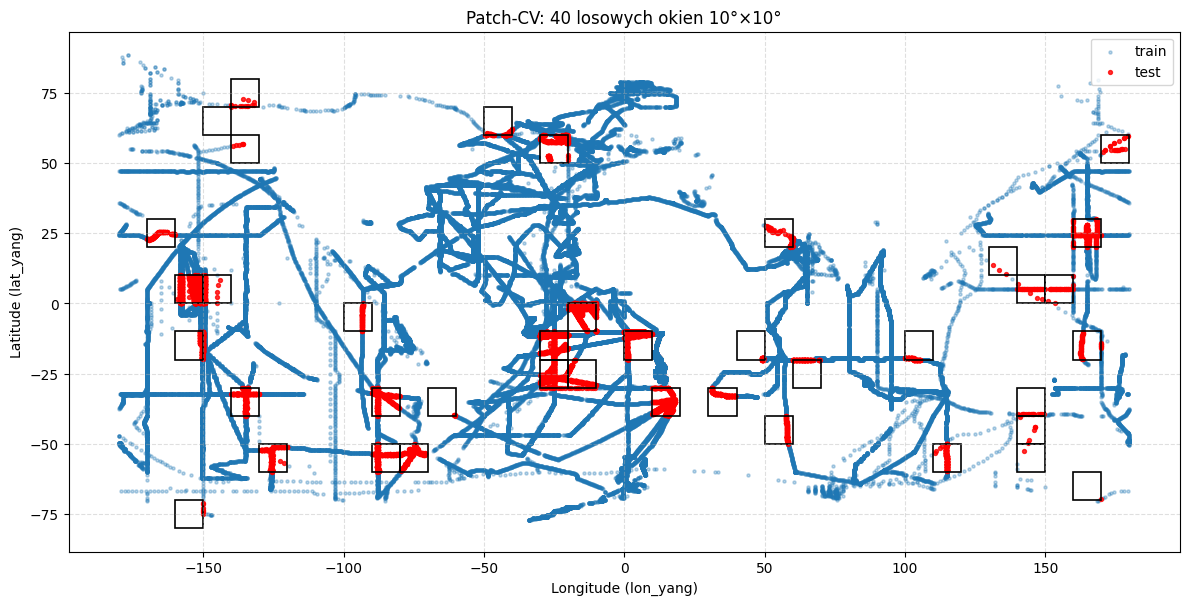

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

fig, ax = plt.subplots(figsize=(12, 6))

# Punkty treningowe (nie w patchach)
ax.scatter(df_joined.loc[~global_test_mask, "lon_yang"],
           df_joined.loc[~global_test_mask, "lat_yang"],
           s=5, alpha=0.3, label="train")

# Punkty testowe (w patchach)
ax.scatter(df_joined.loc[global_test_mask, "lon_yang"],
           df_joined.loc[global_test_mask, "lat_yang"],
           s=8, alpha=0.8, color="red", label="test")

for la0, la1, lo0, lo1 in patch_list:
    ax.add_patch(Rectangle((lo0, la0),
                           lo1 - lo0,
                           la1 - la0,
                           fill=False,
                           edgecolor="black",
                           linewidth=1.2))

ax.set(title="Patch-CV: 40 losowych okien 10°×10°",
       xlabel="Longitude (lon_yang)",
       ylabel="Latitude (lat_yang)")
ax.legend(loc="upper right")
ax.set_aspect("equal", adjustable="box")
ax.grid(ls="--", alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
df_train = df_joined.loc[~global_test_mask].copy()
df_test = df_joined.loc[global_test_mask].copy()

print(f"Train size: {len(df_train)}")
print(f"Test size: {len(df_test)}")

target_col = 'dn2o_ppb'

X_train = df_train.drop(columns=[target_col, 'n2o_ppb', 'n2o_nM', 'lat_yang', 'lon_yang', 'depth_yang', 'n2o_nM','atmPressure', 'salinity'])
y_train = df_train[target_col]

X_test = df_test.drop(columns=[target_col, 'n2o_ppb', 'n2o_nM', 'lat_yang', 'lon_yang', 'depth_yang', 'n2o_nM','atmPressure', 'salinity'])
y_test = df_test[target_col]


Train size: 115162
Test size: 13397


In [ ]:
N_JOBS = -1
SEED = 42

xgb = XGBRegressor(
    n_estimators=600,
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    reg_lambda=1.0,
    device='cuda',
    n_jobs=N_JOBS,
    random_state=SEED,
)

def evaluate(name, y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name:<18} MSE={mse:.4f} RMSE={rmse:.4f} MAE={mae:.4f}  R2={r2:.4f}")


xgb.fit(X_train, y_train)
pred_xgb = xgb.predict(X_test)
evaluate("XGBoost", y_test, pred_xgb)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:09:27] WARNING: /workspace/src/context.cc:43: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [20:09:27] WARNING: /workspace/src/context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBoost            MSE=537.7701 RMSE=23.1899 MAE=12.3099  R2=0.1898
